### Demapper_in file processing

In [3]:
import numpy as np

MAX_LINES = 1000000 # Stop after this many imported lines

# Depends on config that was used for data capture
fn_input = 'logs_Hardware2/demapper_in.txt'

# Read training data from data dump
def read_training_data(in_file, element_shape):
    with open(in_file) as f:
        lines = f.readlines()
    result = None
    i = 0
    while i < len(lines):
        try:
            i = lines.index('QPSK\n', i)
        except ValueError as e:
            break
        num = int(lines[i+1])
        #if num > 30:
        #    print(num)
        data = np.fromstring(' '.join(lines[i+4:i+4+num]), sep=' ', dtype=np.int16).reshape(num, *element_shape)
        if result is None:
            result = data
        else:
            result = np.concatenate((result, data))
        i += 2 + num
        if i>MAX_LINES:
            break
    return result

def int16_to_float16(symbols_i):
    return np.ldexp(symbols_i.astype(np.float32), -8).astype(np.float16)

def float16_to_int16(llrs_h):
    return np.rint(np.ldexp(llrs_h.astype(np.float32), 8)).astype(np.int16)

def norm_int16_to_float16(symbols_i, magnitudes):
    args = symbols_i.astype(np.float32)
    if magnitudes is not None:
        args = args / magnitudes.astype(np.float32)
    return np.ldexp(args, 7).astype(np.float16)

data_in = read_training_data(fn_input, (2, ))


print("data_in.shape: ", data_in.shape)
print("First 5 input symbols:", data_in[0:5,:])


data_in.shape:  (129300, 2)
First 5 input symbols: [[-1166  6382]
 [ 4804   749]
 [-6492  1997]
 [-4678 -5278]
 [ 2295 -2326]]


[-0.43720729-0.62230026j  0.41096915+0.4360665j   0.40868757+0.55813089j
 ... -0.5170625 +0.44718919j -0.50964737-0.50422863j
  0.47742009+0.51848848j]
Saved 119300 elements to demapper_iq_complex.txt
Avg. power after norm: 0.4999999999999998
First 5 input symbols:
 [ 0.3547853 -0.43150334j -0.48027206-0.51820329j  0.41752868+0.50194705j
  0.63741571-0.48369443j]


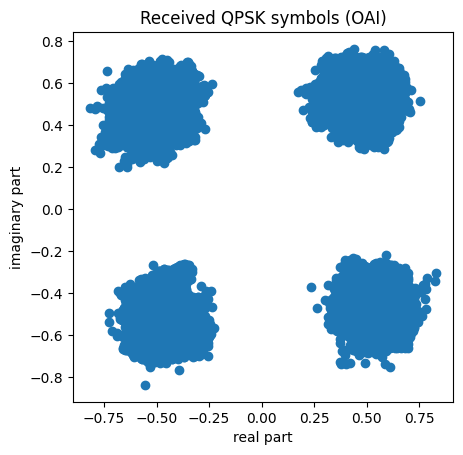

In [5]:
from matplotlib import pyplot as plt

x = data_in [10000 : ]
# OAI uses h as decision region between inner and outer bits
# We scale the received symbols y back such that y_n = y / h
#y_n = x[:,0]/x[:,1] + 1.j*x[:,0]/x[:,1]

y_n= x[:,0]+1.j*x[:,1]

# Normalize to unit power (target E[|y|^2] = 1)

eps = 1e-12

rms = np.sqrt(np.mean(np.abs(y_n)**2) + eps)

y = y_n / rms  # now points are ~on the unit circle
 
# (Optional) map to Sionna’s QPSK grid (±1/√2 on each axis)

y = y * (1/np.sqrt(2))
print(y)
 
# Save rx_iq to text file, 1 element per row (no [])
out_file = "demapper_iq_complex.txt"
with open(out_file, "w") as f:
    for val in y:
        f.write(f"{val}\n")

print(f"Saved {y.shape[0]} elements to {out_file}")


# This normalizes the first decision bound to 1,
# i.e., the center between inner and out constellation points.
# In the Sionna definition (i.e., power normalized QAM),
# the inner/outer points are at 0.3162278 and 0.9486833, respectively.
# Thus we need to scale y_n by s = 0.9486833 - 0.3162278
# s = 0.9486833 - 0.3162278 # outer - inner constellation point
# y = y_n * s

# Calculate average power of received symbols after normalization
avg_power = np.mean(np.abs(y)**2)

# Keep in mind there is some noise variance
print("Avg. power after norm:", avg_power)

# # And plot results
# plt.scatter(y.real, y.imag, label="OAI normalized")
# plt.title("Received QAM symbols (OAI)")
# plt.ylabel("imaginary part")
# plt.xlabel("real part");
# plt.gca().set_aspect('equal', adjustable='box');

# # Overlay with Sionna constellations
# c = sn.phy.mapping.Constellation("qam", 4).points.numpy()
# plt.scatter(c.real, c.imag, label="Sionna QAM-16")
# plt.legend();

# Received symbols
plt.figure()
plt.scatter(y.real, y.imag)
plt.title("Received QPSK symbols (OAI)")
plt.xlabel("real part"); plt.ylabel("imaginary part")
plt.gca().set_aspect('equal', adjustable='box')

print("First 5 input symbols:\n", y[10001 : 10005])

# Constellation (separate figure)
# c = sn.phy.mapping.Constellation("qam", 2).points.numpy()
# plt.figure()
# plt.scatter(c.real, c.imag)
# plt.title("Sionna QAM-16 constellation")
# plt.xlabel("real part"); plt.ylabel("imaginary part")
# plt.gca().set_aspect('equal', adjustable='box')

### RX_Data Processing

In [6]:
import re
import numpy as np

MAX_LINES = 1_000_000

# Patterns
HEADER_MOD_RE = re.compile(r'^[A-Za-z]+[0-9]*$')           # e.g., QPSK, QPSK16
HEADER_SYMBOL_RE = re.compile(r'^SYMBOL:\s*\d+\s*$')
HEADER_NEW_RE = re.compile(r'^(SYMBOL_SIZE|RX_OFFSET|Tag|NB_RE_PUSCH|START_RE)\s*[: ]')  
FLOAT_RE = re.compile(r'^[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?$')
PAIR_RE = re.compile(r'^\s*-?\d+\s+-?\d+\s*$')

def read_training_data(in_file, element_shape=(2,)):
    with open(in_file) as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    out = []
    i = 0
    n = len(lines)

    def is_float(s): return FLOAT_RE.match(s) is not None
    def is_mod(s):   return HEADER_MOD_RE.match(s) is not None and not PAIR_RE.match(s)

    while i < n and i < MAX_LINES:
        # Skip leading floats (timestamps)
        while i < n and is_float(lines[i]):
            i += 1
        if i >= n:
            break

        # Detect header type
        block_pairs = []
        count = None

        # --- Old style: modulation line ---
        if is_mod(lines[i]):
            mod_line = lines[i]
            i += 1

            if i < n and lines[i].isdigit():
                count = int(lines[i]); i += 1

            if i < n and HEADER_SYMBOL_RE.match(lines[i]):
                i += 1
            if i < n and lines[i].lower().startswith("mod_order"):
                i += 1

        # --- New style: SYMBOL_SIZE / RX_OFFSET / etc. ---
        elif HEADER_NEW_RE.match(lines[i]):
            while i < n and HEADER_NEW_RE.match(lines[i]):
                i += 1  # skip metadata headers

        # --- Now read I/Q pairs ---
        if count is not None:
            needed = count
            while i < n and needed > 0:
                if PAIR_RE.match(lines[i]):
                    I, Q = map(int, lines[i].split()[:2])
                    block_pairs.append((I, Q))
                    needed -= 1
                    i += 1
                else:
                    break
        else:
            while i < n:
                s = lines[i]
                if PAIR_RE.match(s):
                    I, Q = map(int, s.split()[:2])
                    block_pairs.append((I, Q))
                    i += 1
                else:
                    if is_float(s) or is_mod(s) or HEADER_SYMBOL_RE.match(s) or HEADER_NEW_RE.match(s):
                        break
                    i += 1

        if block_pairs:
            arr = np.asarray(block_pairs, dtype=np.int16).reshape(-1, *element_shape)
            out.append(arr)

    if not out:
        return np.empty((0, *element_shape), dtype=np.int16)
    return np.concatenate(out, axis=0)

def int16_to_float_unit(iq_int16):
    return iq_int16.astype(np.float32) / (2**15)

# ---- usage ----
fn_input = 'logs_Hardware2/RX_Data.txt'
rx_data_in = read_training_data(fn_input, (2,))
print("data_in.shape:", rx_data_in.shape)
print(rx_data_in.dtype)
print("First 5 input symbols:\n", rx_data_in[:5, :])

rx_iq = (rx_data_in[:,0].astype(np.float32) + 1j*rx_data_in[:,1].astype(np.float32)) / (2**15)
print("iq.shape:", rx_iq.shape)

# Save rx_iq to text file, 1 element per row like list
out_file = "rx_iq_complex.txt"
with open(out_file, "w") as f:
    for val in rx_iq:
        f.write(f"{val}\n")

print(f"Saved {rx_iq.shape[0]} elements to {out_file}")



data_in.shape: (134976, 2)
int16
First 5 input symbols:
 [[ 4275  -413]
 [-1157 -3007]
 [ 3931  2167]
 [  775  4597]
 [-2616  3142]]
iq.shape: (134976,)
Saved 134976 elements to rx_iq_complex.txt


[-0.09347534+0.07312012j -0.08822632+0.09918213j  0.09573364+0.10629272j
 ... -0.12643433+0.0619812j  -0.07650757-0.12643433j
  0.07104492+0.12652588j]
(124976,)
First 5 input symbols:
 [-0.09347534+0.07312012j -0.08822632+0.09918213j  0.09573364+0.10629272j
 -0.14013672-0.08615112j -0.08682251+0.11123657j]


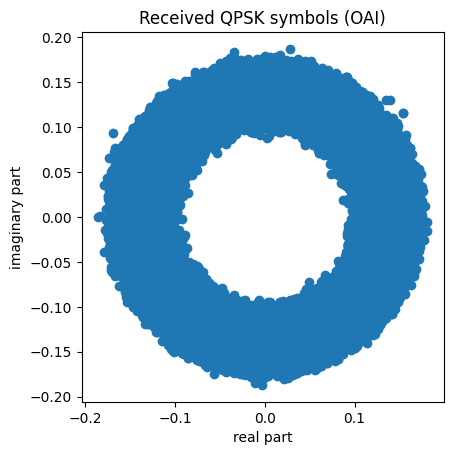

In [7]:
from matplotlib import pyplot as plt
 
rx_y = rx_iq[10000 : ,...]

print(rx_y)
print(rx_y.shape)

print("First 5 input symbols:\n", rx_y[ : 5])

plt.figure()
plt.scatter(rx_y.real, rx_y.imag)
plt.title("Received QPSK symbols (OAI)")
plt.xlabel("real part"); plt.ylabel("imaginary part")
plt.gca().set_aspect('equal', adjustable='box')

In [8]:
import re
import numpy as np

MAX_LINES = 1_000_000

# Patterns
FLOAT_RE = re.compile(r'^[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?$')
PAIR_RE = re.compile(r'^\s*-?\d+\s+-?\d+\s*$')
HEADER_NEW_RE = re.compile(r'^(SYMBOL_SIZE|RX_OFFSET|Tag|NB_RE_PUSCH|START_RE)\s*[: ]')  # new style headers

def read_ch_data(in_file, element_shape=(2,)):
    with open(in_file) as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    out = []
    i = 0
    n = len(lines)

    def is_float(s): return FLOAT_RE.match(s) is not None

    while i < n and i < MAX_LINES:
        # Skip leading floats (timestamps)
        while i < n and is_float(lines[i]):
            i += 1
        if i >= n:
            break

        # Skip new style headers
        while i < n and HEADER_NEW_RE.match(lines[i]):
            i += 1

        # Read I/Q pairs until next header/float
        block_pairs = []
        while i < n:
            s = lines[i]
            if PAIR_RE.match(s):
                I, Q = map(int, s.split()[:2])
                block_pairs.append((I, Q))
                i += 1
            else:
                if is_float(s) or HEADER_NEW_RE.match(s):
                    break
                i += 1

        if block_pairs:
            arr = np.asarray(block_pairs, dtype=np.int16).reshape(-1, *element_shape)
            out.append(arr)

    if not out:
        return np.empty((0, *element_shape), dtype=np.int16)
    return np.concatenate(out, axis=0)

def int16_to_float_unit(iq_int16):
    return iq_int16.astype(np.float32) / (2**15)

# ---- usage ----
fn_input = 'logs_Hardware2/chFext_Data.txt'
ch_data_in = read_ch_data(fn_input, (2,))
print("ch_data_in.shape:", ch_data_in.shape)
print("First 5 input symbols:\n", ch_data_in[:5, :])

# Optional: convert to complex float
ch_iq = (ch_data_in[:,0].astype(np.float32) + 1j*ch_data_in[:,1].astype(np.float32)) / (2**15)
print("iq.shape:", ch_iq.shape)

# Save rx_iq to text file, 1 element per row (no [])
out_file = "logs_Hardware2/ch_iq_complex.txt"
with open(out_file, "w") as f:
    for val in ch_iq:
        f.write(f"{val}\n")

print(f"Saved {ch_iq.shape[0]} elements to {out_file}")



ch_data_in.shape: (134976, 2)
First 5 input symbols:
 [[ -846 -2976]
 [-1541 -2679]
 [-2154 -2228]
 [-2628 -1641]
 [-1631   138]]
iq.shape: (134976,)
Saved 134976 elements to logs_Hardware2/ch_iq_complex.txt


[0.12872314-0.00180054j 0.128479  -0.00802612j 0.12832642-0.01098633j ...
 0.12557983+0.03311157j 0.12582397+0.03167725j 0.12649536+0.02996826j]
(124976,)
First 5 input symbols:
 [0.12872314-0.00180054j 0.128479  -0.00802612j 0.12832642-0.01098633j
 0.1277771 -0.01733398j 0.12783813-0.02337646j]


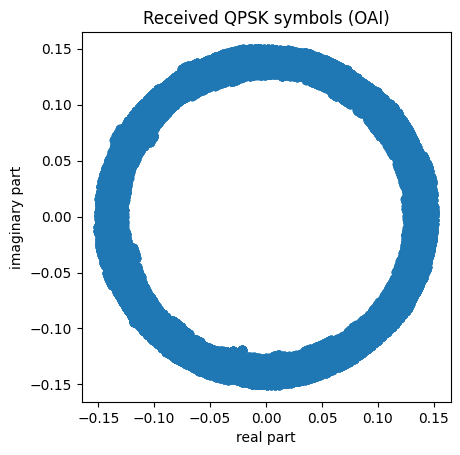

In [9]:
from matplotlib import pyplot as plt
 
ch_y = ch_iq[10000:,...]

print(ch_y)
print(ch_y.shape)

print("First 5 input symbols:\n", ch_y[ : 5])

plt.figure()
plt.scatter(ch_y.real, ch_y.imag)
plt.title("Received QPSK symbols (OAI)")
plt.xlabel("real part"); plt.ylabel("imaginary part")
plt.gca().set_aspect('equal', adjustable='box')

(124976,) (124976,)


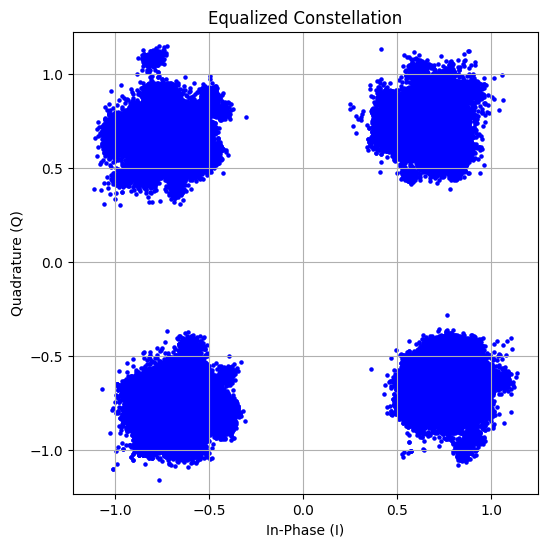

First 5 input symbols:
 [-0.7339755 +0.55777514j -0.73206675+0.7262391j   0.67019176+0.8856763j
 -0.9870977 -0.8081374j  -0.8111496 +0.7218093j ]
First 5 input symbols:
 [-0.43720729-0.62230026j  0.41096915+0.4360665j   0.40868757+0.55813089j
 -0.42437341+0.40669119j  0.43492571+0.45089675j]


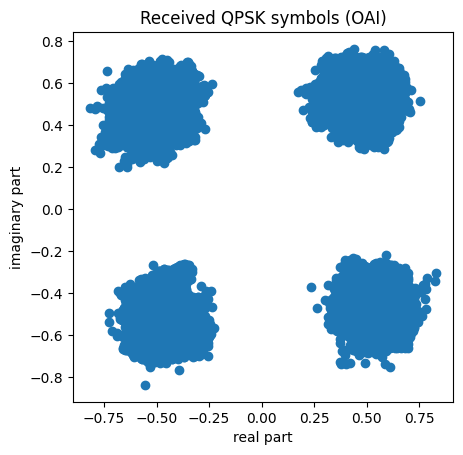

In [10]:
import numpy as np
 
rx_ch_data = rx_y / ch_y    #(rx/ch)
#print(rx_ch_data)
print(rx_y.shape, ch_y.shape)
 
# 2. Remove NaN and Inf
#mask = np.isfinite(rx_ch_data.real) & np.isfinite(rx_ch_data.imag)
#rx_ch_data_clean = rx_ch_data[mask]

eps = 1e-12
rms = np.sqrt(np.mean(np.abs(rx_ch_data)**2) + eps)

rx_ch_data_norm = rx_ch_data / rms  # now points are ~on the unit circle
 
# 3. Plot constellation
plt.figure(figsize=(6,6))
plt.scatter(rx_ch_data_norm.real, rx_ch_data_norm.imag, color='blue', s=5)
plt.grid(True)
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.title('Equalized Constellation')
plt.axis('equal')  # Equal scaling on x and y
plt.show()
 

 
# Received symbols
plt.figure()
plt.scatter(y.real, y.imag)
plt.title("Received QPSK symbols (OAI)")
plt.xlabel("real part"); plt.ylabel("imaginary part")
plt.gca().set_aspect('equal', adjustable='box')

print("First 5 input symbols:\n", rx_y[ : 5] / ch_y[ : 5])
print("First 5 input symbols:\n", y[ : 5])

In [14]:
import numpy as np

# Paste numerator values (real imag format)
num_data = """
3341 1873
4064 1786
1022 -3577
1501 -3746
4414 2038
"""

# Paste denominator values (real imag format)
den_data = """
-4254 1324
-4223 1423
-4187 1540
-4140 1634
-4106 1904
"""

# Convert string to numpy arrays
num = np.loadtxt(num_data.splitlines())
den = np.loadtxt(den_data.splitlines())

# Convert to complex numbers
num_c = num[:,0] + 1j * num[:,1]
den_c = den[:,0] + 1j * den[:,1]

# Division
result = num_c / den_c

# Print results in (real imag) format
for r in result:
    print(f"{r.real:.6f} {r.imag:.6f}")



-0.591086 -0.624259
-0.736243 -0.671010
-0.491780 0.673432
-0.622685 0.659066
-0.695334 -0.818781


In [50]:
import numpy as np

def construct_grid_from_y(y, num_layers=1, num_subcarriers=96, num_symbols=10):
    """
    Reshape complex-valued flat array `y` into a resource grid.
    Expected total size: num_layers * num_subcarriers * num_symbols
    Returns: grid of shape [layers, subcarriers, symbols]
    """
    expected_len = num_layers * num_subcarriers * num_symbols
    if y.size != expected_len:
        raise ValueError(f"Expected {expected_len} complex samples, got {y.size}")

    grid = y.reshape((num_layers, num_subcarriers, num_symbols))
    return grid


input_grid = rx_ch_data_clean[:960]
 
grid = construct_grid_from_y(input_grid)

# Step 3: Check
print("Grid shape:", grid.shape)    # (1, 96, 10)
print("Sample [0, :5, 0]:", grid[0, :5, 0])  # First 5 subcarriers of symbol 0

Grid shape: (1, 96, 10)
Sample [0, :5, 0]: [ 0.00436204-0.03379171j  0.01351913+0.02340719j -0.07574616-0.0511327j
 -0.02092635+0.01822013j -0.0811614 +0.01783245j]


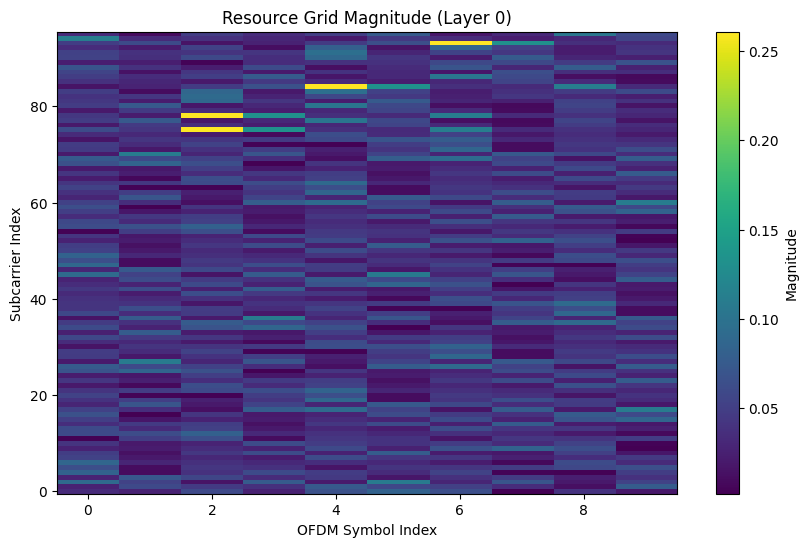

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(np.abs(grid[0]), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('OFDM Symbol Index')
plt.ylabel('Subcarrier Index')
plt.title('Resource Grid Magnitude (Layer 0)')
plt.show()